In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Process

* Set imports
* Define model architecture
* set device(GPU or CPU)
* Define hyperparameters
* Create your(custom) Dataset(inherits from the Dataset class)
    * Define DataSets
    * Define DataLoaders
* initialize/instantiate network
* Compile model
    * Define loss
    * Define optimizer
* Train the network (create training for loop)
    set model to training mode? model.train()?
    * for epochs
        * for batch, features, labels in DataLoader
            * set data to the device(import for cuda, ie. gpu enabled)
            * Forward pass: predictions and loss
            * Backward pass: optimizer.zero_grad() & loss.backward()
            * Gradient descent: optimizer.step()
* Define testing/validation loop
    * remember: set model to evaluation mode(with torch.zero_grad??? or model.eval()???)
    

* Data Augmentation (extra step for image data)
    * Done with PyTorch Transforms
    * `import torchvision.transforms as transforms`
    * `my_transforms = transforms.Compose([your list of transformations go here])`
    * tranforms get implemented in datasets when you include them in the `transforms` argument of the dataset

In [2]:
# imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from tqdm import tqdm  
import torchvision.transforms as transforms

import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Hyperparameters
learning_rate = 0.001 #3e-4 #0.001
batch_size = 64 #24 #256 #80 #16 #32 #64

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")

In [6]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
# df = df[["image_name","target"]].sample(3000, random_state=125)

In [8]:
# df[["image_name","target"]][df["target"] == 1].info()

In [9]:
# Dataset
class Melanoma_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        length = self.annotations.shape[0]
        return length
    
    def __getitem__(self, idx):
        image_name = self.annotations["image_name"].iloc[idx]
        target = self.annotations["target"].iloc[idx]
        image_path = self.root_dir + "/" + image_name + ".jpg"
        image = img.imread(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        target = torch.tensor([target], dtype=torch.float32)
            
        return image, target

In [10]:
# vgg_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/vgg16bn_base_state_dict_new.pt", map_location=device)
# wideresnet_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/wideresnet50_base_state_dict_new.pt", map_location=device)
# resnext_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/resnext50_base_state_dict_new.pt", map_location=device)

In [11]:
# base_model = torchvision.models.wide_resnet50_2(pretrained=True)
# torch.save(base_model, "./wide_resnet50_2.pt") # saves to "output"

vgg16_base_model = torch.load("../input/siimmelanomatrainedmodels/vgg16_bn.pt")
wideresnet50_base_model = torch.load("../input/siimmelanomatrainedmodels/wide_resnet50_2.pt")
resnext50_base_model = torch.load("../input/siimmelanomatrainedmodels/resnext50_32x4d.pt")

# vgg16_base_model.load_state_dict(vgg_base_state)
# wideresnet50_base_model.load_state_dict(wideresnet_base_state)
# resnext50_base_model.load_state_dict(resnext_base_state)

In [12]:
print(vgg16_base_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
class EnsembleModel(nn.Module):
    def __init__(self, trainable=[False, False, False, True]):
        super(EnsembleModel, self).__init__()
        
        self.wide_resnet50_base = wideresnet50_base_model
        self.vgg16_base = vgg16_base_model
        self.resnext50_base = resnext50_base_model

        for param in self.wide_resnet50_base.parameters():
            param.requires_grad = trainable[0]
            
        for param in self.vgg16_base.parameters():
            param.requires_grad = trainable[1]
            
        for param in self.resnext50_base.parameters():
            param.requires_grad = trainable[2]
        
        self.fc1 = nn.Linear(3000, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 1000)
        self.fc4 = nn.Linear(1000, 500)
        self.fc5 = nn.Linear(500, 100)
        self.fc6 = nn.Linear(100, 1)
        
        end_layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]
        
        for layer in end_layers:
            layer.requires_grad = trainable[3]
        
    def forward(self, x):
        x1 = self.wide_resnet50_base(x)
        x2 = self.resnext50_base(x)
        x3 = self.vgg16_base(x)
        
        x = torch.cat((x1,x2,x3), dim=1)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
#         x = torch.nn.functional.relu(self.fc1(x))
#         x = torch.nn.functional.relu(self.fc2(x))
#         x = (x1 + x2 + x3)/3.0
        return x

In [14]:
# model = EnsembleModel()

# model.state_dict().keys()

In [15]:
# augmentations/transforms
images_mean = (0.8060590931711208, 0.620982283291032, 0.5915027590675953)
images_std = (0.08131081913267031, 0.09455098010432171, 0.10589780296354254)
image_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
        #transforms.Grayscale(num_output_channels=3),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
        #transforms.Grayscale(num_output_channels=3),
    ]
)

In [16]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=125)

In [17]:
total_samples = len(train_df["target"])
class_1_count = sum(train_df["target"]) + 0.0001 #in case class_1_count is zero
class_0_count = total_samples - class_1_count
class_weights = [total_samples/class_0_count, total_samples/class_1_count]

list_of_weights = [class_weights[i] for i in train_df["target"]]
weighted_sampler = WeightedRandomSampler(list_of_weights, num_samples = len(list_of_weights), replacement=True)

In [18]:
# # Instantiate Datasets and DataLoaders
# # root_directory = "../input/siim-isic-melanoma-classification/jpeg/train"
root_directory = "../input/siimisic-resized-224x224-jpeg/output_train/train"

train_ds = Melanoma_Dataset(train_df, root_dir=root_directory, transform=image_transforms)
test_ds = Melanoma_Dataset(test_df, root_dir=root_directory, transform=image_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, sampler=weighted_sampler,
                          num_workers=1, pin_memory=True, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, 
                         num_workers=1, pin_memory=True, shuffle=True)

In [19]:
# ## Code used to remove layers of pretrained models. Leaving only the "base" layers
# ## So we can give our base models for the ensemble our pre-trained weights

# # Load checkpoints

# vgg16_checkpoint = torch.load("../input/siimmelanomatrainedmodels/Model State_Dicts New/Model State_Dicts New/VGG16_bn_model_checkpoint_epoch_6.pt", 
#                               map_location=device)
# wideresnet50_checkpoint = torch.load("../input/siimmelanomatrainedmodels/Model State_Dicts New/Model State_Dicts New/WideResnet50_model_checkpoint_epoch_4.pt", 
#                                      map_location=device)
# resnext50_checkpoint = torch.load("../input/siimmelanomatrainedmodels/Model State_Dicts New/Model State_Dicts New/resnext50_model_checkpoint_epoch_5.pt", 
#                                   map_location=device)


# # remove layers we added. Leaving only the original layers(with our new weights)
# vgg_model_state = vgg16_checkpoint["model_state"]
# wideresnet_model_state = wideresnet50_checkpoint["model_state"]
# resnext_model_state = resnext50_checkpoint["model_state"]



# layers_to_delete = ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
# for weights in layers_to_delete:
#     del vgg_model_state[weights]
#     del wideresnet_model_state[weights]
#     del resnext_model_state[weights]
    
# # rename the layers, by creating and saving new OrderedDict
# import re
# from collections import OrderedDict


# def remove_base_from_name(text, base):
#     pattern = re.compile(fr"({base})(.*)")
#     new_text = pattern.sub(r'\2',text)
#     return new_text


# def change_weight_names(model_state_dict, name_appendix):
# # eg. name appendix = "vgg16_base."
#     new_ordered_dict = OrderedDict()
#     for layer in model_state_dict:
#         new_name = remove_base_from_name(layer, name_appendix)
#         new_ordered_dict[new_name] = model_state_dict[layer]
    
#     return new_ordered_dict


# vgg_model_state_new = change_weight_names(vgg_model_state, "vgg16_base.")
# wideresnet_model_state_new = change_weight_names(wideresnet_model_state, "wide_resnet50_base.")
# resnext_model_state_new = change_weight_names(resnext_model_state, "resnext50_base.")


# # load new state_dict to base models
# vgg16_base_model.load_state_dict(vgg_model_state_new)
# wideresnet50_base_model.load_state_dict(wideresnet_model_state_new)
# resnext50_base_model.load_state_dict(resnext_model_state_new)

# # save new state_dict's
# torch.save(vgg_model_state_new, "./vgg16bn_base_state_dict_new.pt")
# torch.save(wideresnet_model_state_new, "./wideresnet50_base_state_dict_new.pt")
# torch.save(resnext_model_state_new, "./resnext50_base_state_dict_new.pt")

In [20]:
model = EnsembleModel(trainable=[False, False, False, False]).to(device)

In [21]:
# Ensemble_model_state = torch.load("../input/siimmelanomatrainedmodels/Ensemble_model_final_checkpoint_epoch_4.pt", 
#                                   map_location=device)
Ensemble_model_state = torch.load("../input/siimmelanomatrainedmodels/Ensemble_model_final_checkpoint_epoch_8.pt", 
                                  map_location=device)
# Ensemble_model_state = torch.load("./Ensemble_model_grayscale_checkpoint_epoch_6.pt", 
#                                   map_location=device)

# Ensemble_model_state.keys()

model.load_state_dict(Ensemble_model_state["model_state"])

<All keys matched successfully>

In [22]:
Ensemble_model_state.keys()

dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'loss', 'auc'])

In [23]:
print(Ensemble_model_state["loss"])
print(Ensemble_model_state["auc"])

8.92511504026759e-05
0.9054578076166223


In [24]:
# Focal Loss Function
# from this blog post: https://amaarora.github.io/2020/06/29/FocalLoss.html

class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).to(device)  #.cuda() #remember to define "device"
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [25]:
# # Loss and optimizer
# # loss_function = nn.BCEWithLogitsLoss() 
# loss_function = WeightedFocalLoss(alpha=0.25, gamma=2.0)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
# # learning rate scheduler
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, 
#                                               max_lr=0.1,step_size_up=5,mode="triangular2")


# loss_function = loss_function = WeightedFocalLoss(alpha=0.25, gamma=2.0)
loss_function = loss_function = WeightedFocalLoss(alpha=0.25, gamma=2.0)


# from abishek thakur: https://www.kaggle.com/abhishek/melanoma-detection-with-pytorch?scriptVersionId=35193166
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience=3, 
                                                       threshold=0.001, 
                                                       mode="max"
                                                      )

In [26]:
import math

# # from documentation: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    print(f"Total samples: {size}")
    print(f"Batch size: {batch_size}")
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device=device)
        y = y.to(device=device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         scheduler.step(loss)
        print(f"Batch number: {batch+1}/{math.ceil(size/batch_size)}", end="\r")
    
    print("\n")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    model.eval()
    
    predictions = []
    targets = []
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device=device)
            y = y.to(device=device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel() #test_df["target"].values
    auc = sklearn.metrics.roc_auc_score(targets, predictions)

    test_loss /= size
#     auc /= size
    # print(f"Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss}, AUC = {auc} \n")
    
    return test_loss, auc

In [27]:
# Training Loop with AMP(automatic mixed precision)

# mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

def train_loop_amp(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    print(f"Total samples: {size}")
    print(f"Batch size: {batch_size}")
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device=device)
        y = y.to(device=device)
        
        
        # forward
        with torch.cuda.amp.autocast():
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        print(f"Batch number: {batch+1}/{math.ceil(size/batch_size)}", end="\r")
    
    print("\n")

In [28]:
print(device)

cuda


In [29]:
# def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=5):
#     # lowest_loss = np.inf #float("inf")
#     top_3_models = []
#     for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
# #         if device == "cuda":
# #             train_loop_amp(train_loader, model, loss_function, optimizer)
# #         else:
# #             train_loop(train_loader, model, loss_function, optimizer)


#         train_loop(train_loader, model, loss_function, optimizer)
#         test_loss = test_loop(test_loader, model, loss_function)
        
#         # saving model checkpoint
#         checkpoint = {"epoch": t+1, 
#                       "model_state": model.state_dict(), 
#                       "optimizer_state": optimizer.state_dict(),
#                       "scheduler_state": scheduler.state_dict(), 
#                       "loss": test_loss}
        
#         if len(top_3_models) == 0:
#             torch.save(checkpoint, f"./resnext50_model_checkpoint_epoch_{t+1}.pt")
#             top_3_models.append({"filename": f"./resnext50_model_checkpoint_epoch_{t+1}.pt", 
#                                  "loss": test_loss})
        
#         if test_loss < top_3_models[0]["loss"]:
#             torch.save(checkpoint, f"./resnext50_model_checkpoint_epoch_{t+1}.pt")
#             top_3_models.append({"filename": f"./resnext50_model_checkpoint_epoch_{t+1}.pt", 
#                                  "loss": test_loss})

#         if len(top_3_models) > 3:
#             file_to_remove = top_3_models[0]["filename"]
#             os.remove(file_to_remove)
#             top_3_models.pop(0)

#         # sort in descending order by loss 
#         top_3_models = sorted(top_3_models, key=lambda k: k["loss"], reverse=True)
            
#         # print(f"top_3_models length: {len(top_3_models)}")
            
#     print("Done!")
    
#     return model


def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=5, epochs_pretrained=0):
    # lowest_loss = np.inf #float("inf")
    top_3_models = []
    for t in range(epochs):
        print(f"Epoch {t+1}[{epochs_pretrained+t+1} in total]\n-------------------------------")
#         if device == "cuda":
#             train_loop_amp(train_loader, model, loss_function, optimizer)
#         else:
#             train_loop(train_loader, model, loss_function, optimizer)


        train_loop(train_loader, model, loss_function, optimizer)
        test_loss, test_auc = test_loop(test_loader, model, loss_function)
        
        scheduler.step(test_auc)
        # saving model checkpoint
        checkpoint = {"epoch": epochs_pretrained+t+1, 
                      "model_state": model.state_dict(), 
                      "optimizer_state": optimizer.state_dict(),
                      "scheduler_state": scheduler.state_dict(), 
                      "loss": test_loss, 
                      "auc": test_auc}
        
        save_location = f"./Ensemble_model_grayscale_2_checkpoint_epoch_{epochs_pretrained+t+1}.pt"
        
        # always save on first epoch
        if len(top_3_models) == 0:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # save if loss is lower than highest/worst loss of saved models
        if test_loss < top_3_models[0]["loss"]:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # removes worst performing model, but only if there are 3 or more models already saved
        # keeps the 3 best models(measured by loss on validation set)
        if len(top_3_models) > 3:
            file_to_remove = top_3_models[0]["filename"]
            os.remove(file_to_remove)
            top_3_models.pop(0)

        # sort in descending order by loss 
        top_3_models = sorted(top_3_models, key=lambda k: k["loss"], reverse=True)
            
        # print(f"top_3_models length: {len(top_3_models)}")
        
        # always save last epoch
        if t == epochs-1:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
            
    print("Done!")
    
    return model

In [30]:
# optimizer.state_dict()

In [31]:
# model = torch.load("../input/wide-resnet-melanoma-prediction/WideResnet50_trained_10_epochs.pt").to(device)

In [32]:
# model = train_model(model, train_loader, test_loader, loss_function, optimizer, 
#                     epochs=10, epochs_pretrained=0) #Ensemble_model_state["epoch"])

In [33]:
# def get_predictions(dataloader, model):
#     predictions = []
#     model.eval()

#     with torch.no_grad():
#         for X, y in dataloader:
#             X = X.to(device=device)
#             pred = model(X)
#             for value in pred:
#                 predictions.append(value.cpu().numpy()[0])
            
#     return predictions

# def predict_multiple_epochs(dataloader, model, epochs=1):
#     # Note: must use dataloader with batch_size=1
#     predictions = np.zeros(len(dataloader.dataset))
#     model.eval()
    
#     for i in range(epochs):
#         j = 0
#         with torch.no_grad():
#             for X, y in dataloader:
#                 X = X.to(device=device)
#                 pred = model(X)
#                 predictions[j] += pred[0][0].cpu().numpy()
#                 j += 1

#         print(f"Epoch: {i+1}")
        
#     predictions = predictions * (1.0/epochs)
            
#     return predictions

In [34]:
def get_predictions(dataloader, model):
    predictions = []
    targets = []
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=device)
            pred = model(X)
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel()
            
    return predictions, targets


def predict_multiple_epochs(dataloader, model, epochs=1):
    # Note: must use dataloader with batch_size=1
    predictions = []
    targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        pred, targ = get_predictions(dataloader, model)
        predictions.append(pred)
        if i == 0:
            targets.append(targ)
            
    targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)

    return predictions, targets

In [35]:
# Reset test loader with batch_size=1
# so that we can use our predict_multiple_epochs function
# to perform test-time augmentation
# test_loader_new = DataLoader(dataset=test_ds, batch_size=1, 
#                              num_workers=1, pin_memory=True, shuffle=False)

def predict_multiple_epochs_TWO(test_df, model, epochs=1):
    # Note: must use dataloader with batch_size=1
    predictions = []
    targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        
        test_ds_new = Melanoma_Dataset(test_df, root_dir=root_directory, transform=test_transforms) #image_transforms)
        test_loader_new = DataLoader(dataset=test_ds_new, batch_size=1, num_workers=1, pin_memory=True, shuffle=False)
        
        pred, targ = get_predictions(test_loader_new, model)
        predictions.append(pred)
        if i == 0:
            targets.append(targ)
            
    targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)

    return predictions, targets
# test_ds_new = Melanoma_Dataset(test_df, root_dir=root_directory, transform=image_transforms)
# test_loader_new = DataLoader(dataset=test_ds, batch_size=1, 
#                          num_workers=1, pin_memory=True, shuffle=False)

In [36]:
# predictions, targets = predict_multiple_epochs(test_loader_new, model, epochs=1)
# predictions = get_predictions(test_loader, model)

# predictions, targets = predict_multiple_epochs_TWO(test_df, model, epochs=1)

In [37]:
# print(f"AUC: {sklearn.metrics.roc_auc_score(targets, predictions)}")

In [38]:
# plt.hist(predictions, bins=20) #, range=(0,1))
# plt.show()

In [39]:
# filtered_predictions = []
# for pred in predictions:
#     if pred < -3.5:
#         filtered_predictions.append(0)
#     else:
#         filtered_predictions.append(1)

In [40]:
# test_labels = test_df["target"].values

In [41]:
# print(classification_report(test_labels, filtered_predictions))

In [42]:
# conf_matrix = confusion_matrix(test_labels, filtered_predictions)

# plt.figure(figsize=(14,7))
# sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues', fmt='g')
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")

# Predicting on the Test set

In [43]:
testing_df = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

In [44]:
testing_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [45]:
# Test Dataset class: Test set doesn't have a target
class Melanoma_Test_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        length = self.annotations.shape[0]
        return length
    
    def __getitem__(self, idx):
        image_name = self.annotations["image_name"].iloc[idx]
        image_path = self.root_dir + "/" + image_name + ".jpg"
        image = img.imread(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image

In [46]:
root_directory = "../input/siimisic-resized-224x224-jpeg/output_test/test"


# test_ds_new = Melanoma_Test_Dataset(testing_df, root_dir=root_directory, transform=image_transforms) #image_transforms)
# test_loader_new = DataLoader(dataset=test_ds_new, batch_size=1, num_workers=1, pin_memory=True, shuffle=False)


In [51]:
def get_predictions_2(dataloader, model):
    predictions = []
    #targets = []
    model.eval()

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device=device)
            pred = model(X)
            predictions.append(pred.cpu())
            #targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    #targets = np.vstack(targets).ravel()
            
    return predictions

def predict_multiple_epochs_2(test_df, model, epochs=1):
    # Note: must use dataloader with batch_size=1
    predictions = []
    #targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        
        test_ds_new = Melanoma_Test_Dataset(test_df, root_dir=root_directory, transform=image_transforms) #image_transforms)
        test_loader_new = DataLoader(dataset=test_ds_new, batch_size=1, num_workers=1, pin_memory=True, shuffle=False)
        
        pred = get_predictions_2(test_loader_new, model)
        predictions.append(pred)
#         if i == 0:
#             targets.append(targ)
            
    #targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)

    return predictions

In [53]:
# predictions = predict_multiple_epochs_2(test_loader_new, model, epochs=10)
predictions = predict_multiple_epochs_2(testing_df, model, epochs=10)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


In [54]:
pred_tensor = torch.Tensor(predictions)

In [55]:
pred = torch.sigmoid(pred_tensor)

pred = pred.cpu().numpy()

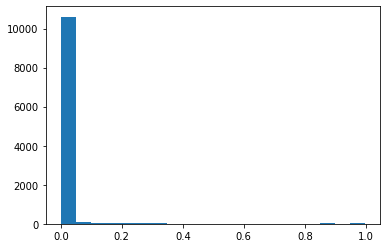

In [56]:
plt.hist(pred, bins=20) #, range=(0,1))
plt.show()

In [57]:
testing_df["target"] = pred
submission_df = testing_df[["image_name", "target"]]

In [58]:
submission_df.head()

,image_name,target
0,ISIC_0052060,7.940415e-09
1,ISIC_0052349,7.659776e-10
2,ISIC_0058510,5.022477e-09
3,ISIC_0073313,9.466502e-10
4,ISIC_0073502,4.314688e-06


In [59]:
submission_df.to_csv("ensemble_model_predictions_2.csv", index=False)